In [1]:
import numpy as np
from scipy import signal
import scipy.stats as stats
import cv2
import imutils
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Fourier transform of an image

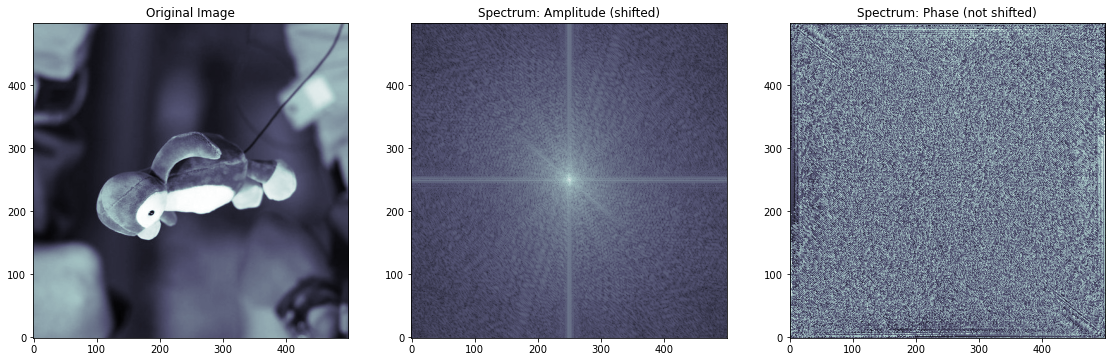

In [2]:
plt.figure(figsize=(6.4*3, 4.8*3), constrained_layout=False)

#Open image and FT:
image = cv2.imread("./Penguin_fly_sq_bw.jpg", 0)
ft_image = np.fft.fft2(image)
ftshift_image = np.fft.fftshift(ft_image)

plt.subplot(131), plt.imshow(image, 'bone', origin='lower'), plt.title("Original Image")
plt.subplot(132), plt.imshow(np.log(1+np.abs(ftshift_image)), 'bone', origin='lower'), plt.title("Spectrum: Amplitude (shifted)")
plt.subplot(133), plt.imshow(np.angle(ft_image), 'bone', origin='lower'), plt.title("Spectrum: Phase (not shifted)")
plt.show()

## 1. Phase and amplitude information

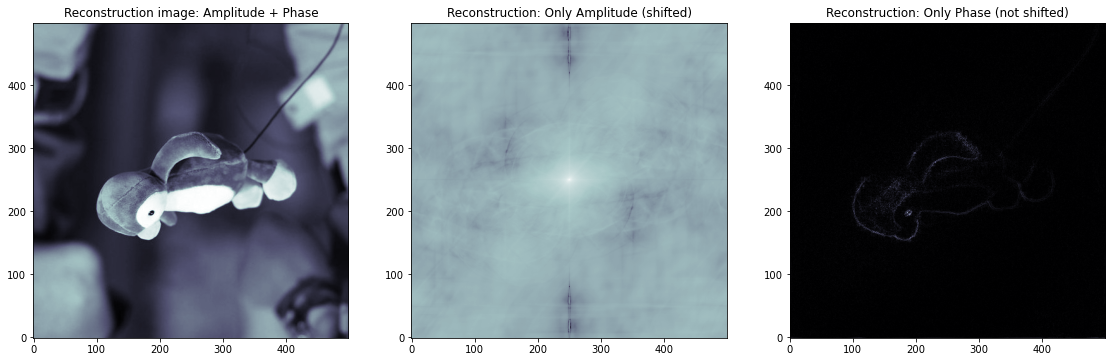

In [3]:
plt.figure(figsize=(6.4*3, 4.8*3), constrained_layout=False)

# Two equivalent ways of reconstructing image
rec1_img = np.fft.ifft2(np.real(ft_image)+np.complex(0,1)*np.imag(ft_image))
rec2_img = np.fft.ifft2(np.abs(ft_image)*np.exp(np.complex(0,1)*np.angle(ft_image)))

rec_ampli = np.fft.ifftshift (np.fft.ifft2((np.abs(ft_image))))
rec_phase = np.fft.ifft2(np.fft.ifftshift (np.exp(np.complex(0,1)*np.angle(ft_image))))

plt.subplot(131), plt.imshow(np.abs(rec2_img), 'bone', origin='lower'), plt.title("Reconstruction image: Amplitude + Phase")
plt.subplot(132), plt.imshow(np.power(np.abs(rec_ampli),0.01), 'bone', origin='lower'), plt.title("Reconstruction: Only Amplitude (shifted)")
plt.subplot(133), plt.imshow(np.abs(rec_phase), 'bone', origin='lower'), plt.title("Reconstruction: Only Phase (not shifted)")
plt.show()

### Difference between original and Fourier reconstruction

1.1368683772161603e-13
-1.1368683772161603e-13


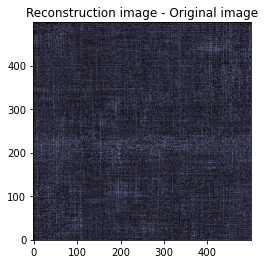

In [4]:
diff_ft_ori = rec2_img-image
plt.imshow(np.abs(diff_ft_ori), 'bone', origin='lower'), plt.title("Reconstruction image - Original image")
print(np.real(np.max(diff_ft_ori)))
print(np.real(np.min(diff_ft_ori)))
plt.show()

## 2. Mixing two images

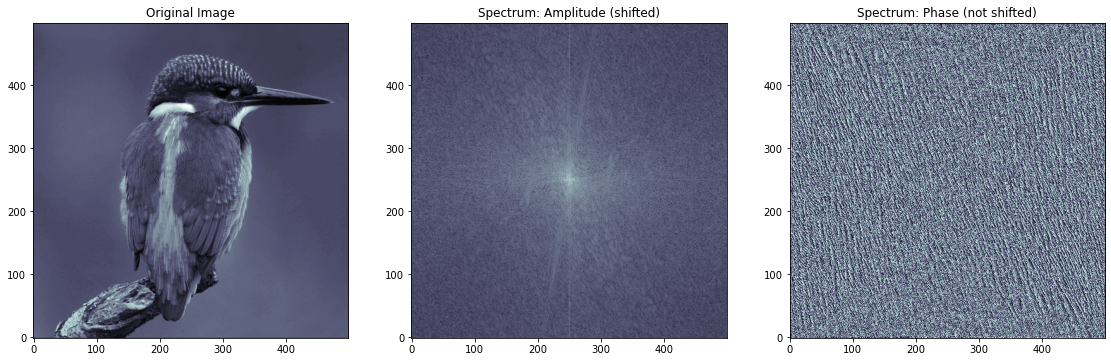

In [8]:
plt.figure(figsize=(6.4*3, 4.8*3), constrained_layout=False)

image2_derot = cv2.imread("./Martin_square.jpg", 0)
image2_rot = imutils.rotate(image2_derot, angle=180)
image2 = cv2.resize(image2_rot, np.shape(image), interpolation = cv2.INTER_AREA)
ft_image2 = np.fft.fft2(image2)
ftshift_image2 = np.fft.fftshift(ft_image2)

plt.subplot(131), plt.imshow(image2, 'bone', origin='lower'), plt.title("Original Image")
plt.subplot(132), plt.imshow(np.log(1+np.abs(ftshift_image2)), 'bone', origin='lower'), plt.title("Spectrum: Amplitude (shifted)")
plt.subplot(133), plt.imshow(np.angle(ft_image2), 'bone', origin='lower'), plt.title("Spectrum: Phase (not shifted)")
plt.show()

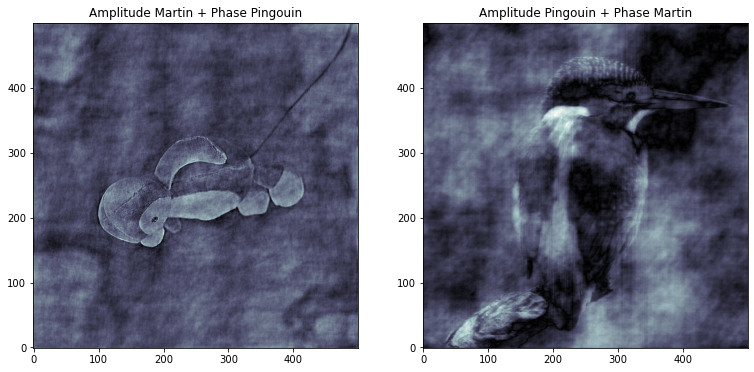

In [6]:
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)

rec12_img = np.fft.ifft2(np.abs(ft_image)*np.exp(np.complex(0,1)*np.angle(ft_image2)))
rec21_img = np.fft.ifft2(np.abs(ft_image2)*np.exp(np.complex(0,1)*np.angle(ft_image)))

plt.subplot(122), plt.imshow(np.abs(rec12_img), 'bone', origin='lower'), plt.title("Amplitude Pingouin + Phase Martin")
plt.subplot(121), plt.imshow(np.abs(rec21_img), 'bone', origin='lower'), plt.title("Amplitude Martin + Phase Pingouin")
plt.show()

## 3. Filtering images

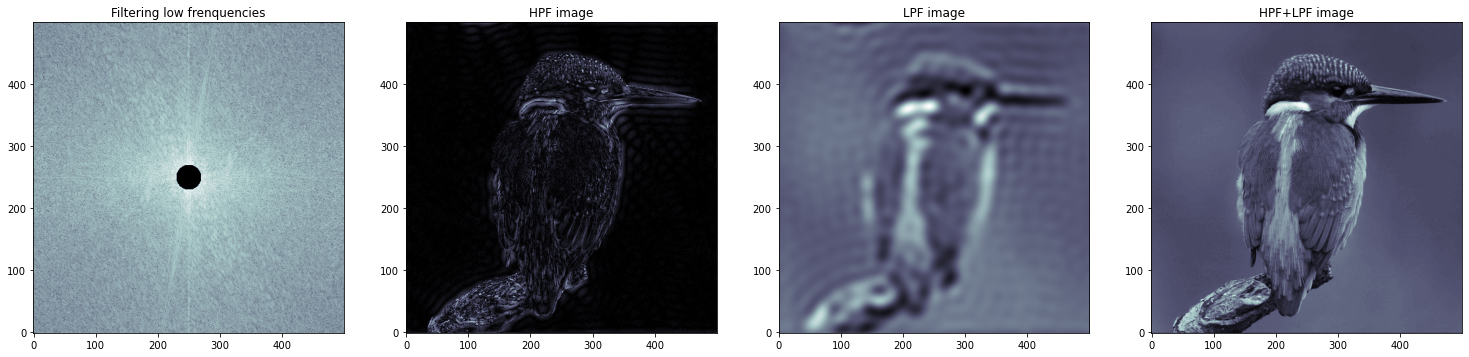

In [18]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

mask_radius = 20
newy, newx = np.mgrid[:np.shape(image2)[0],:np.shape(image2)[0]]-np.shape(image2)[0]/2.
mask = (newx)**2 + (newy)**2 < mask_radius**2

#Filtered frequencies with the masl:
filtered_highpass = ftshift_image2 * (1-mask)
plt.subplot(141), plt.imshow(np.log(1+np.abs(filtered_highpass)), 'bone', origin='lower'), plt.title("Filtering low frenquencies")

#high-pass filtered part:
rec_hpf = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_highpass))*np.exp(np.complex(0,1)*np.angle(ft_image2)))
plt.subplot(142), plt.imshow(np.abs(rec_hpf), 'bone', origin='lower'), plt.title("HPF image")

#low-pass filtered part:
rec_lpf = np.fft.ifft2(np.abs(np.fft.ifftshift(ftshift_image2 * mask))*np.exp(np.complex(0,1)*np.angle(ft_image2)))
plt.subplot(143), plt.imshow(np.abs(rec_lpf), 'bone', origin='lower'), plt.title("LPF image")

#reconstructed image:
rec_all = rec_lpf+rec_hpf
plt.subplot(144), plt.imshow(np.abs(rec_all), 'bone', origin='lower'), plt.title("HPF+LPF image")

plt.show()

And looking at the residuals:

9.947598300641403e-14
-8.526512829121202e-14


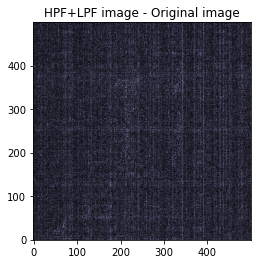

In [19]:
diff_filt_ori = rec_lpf+rec_hpf-image2
plt.imshow(np.abs(diff_filt_ori), 'bone', origin='lower'), plt.title("HPF+LPF image - Original image")
print(np.real(np.max(diff_filt_ori)))
print(np.real(np.min(diff_filt_ori)))
plt.show()

## Filtering images: different filter profiles

In [20]:
#Function to fill an image with a circular profile (centered)
def filter_2d(filter_1d, Nframe):
    diam = np.shape(filter_1d)[0]
    x_vec = np.arange(diam)-diam//2
    x_arr,y_arr = np.meshgrid(x_vec,x_vec)
    circ_r =np.sqrt(x_arr**2+y_arr**2)
    #Fill each radius with the filter value
    filter_2d = np.zeros((diam,diam))
    for i in range(0,diam//2-1):
        circ_ext = np.where((circ_r < i+1), 1, 0)
        circ_int = np.where((circ_r >= i), 1, 0)
        ann = circ_int*circ_ext
        idm = np.where(ann !=0)
        filter_2d[idm]=filter_1d[diam//2+i]
    #Input into a larger window
    filter_full = np.zeros((Nframe,Nframe))
    filter_full[Nframe//2-diam//2:Nframe//2+diam//2,Nframe//2-diam//2:Nframe//2+diam//2] = filter_2d
    return filter_full

In [21]:
Nframe = np.shape(image)[0]
diameter_filter = 40

### 1- Gaussian profile

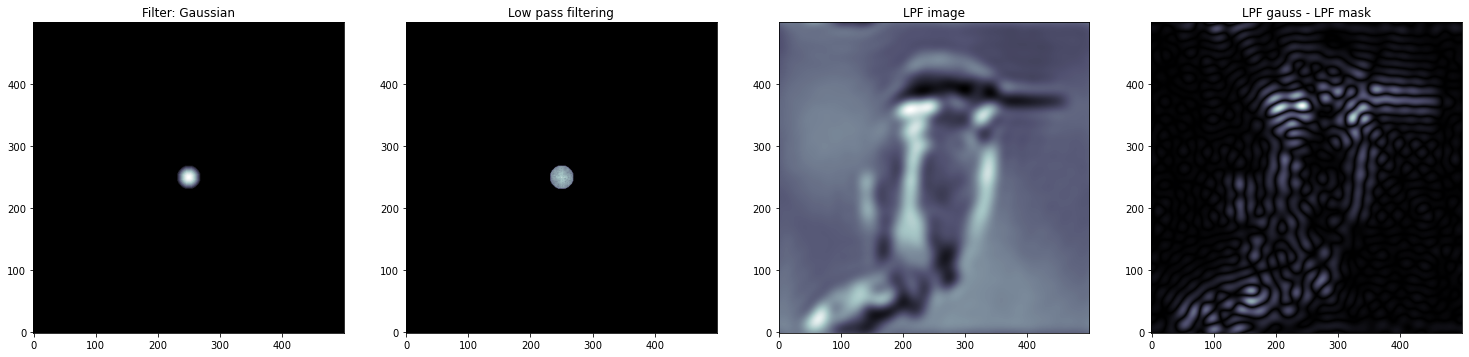

In [22]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

# Making filter
x = np.arange(diameter_filter)-diameter_filter//2 
gauss = stats.norm.pdf(x, 0, diameter_filter//2)
filter_1d_gauss = (gauss-np.min(gauss))/np.max(gauss-np.min(gauss))
gauss_filter = filter_2d(filter_1d_gauss, Nframe)

filtered_hpf = ftshift_image2 * (1-gauss_filter)
filtered_lpf = ftshift_image2 * (gauss_filter)

rec_hpfg = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_hpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))
rec_lpfg = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_lpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))

plt.subplot(141), plt.imshow(gauss_filter, 'bone', origin='lower'), plt.title("Filter: Gaussian")
plt.subplot(142), plt.imshow(np.log(1+np.abs(filtered_lpf)), 'bone', origin='lower'), plt.title("Low pass filtering")
#plt.subplot(143), plt.imshow(np.abs(rec_hpfg), 'bone', origin='lower'), plt.title("HPF image")
plt.subplot(143), plt.imshow(np.abs(rec_lpfg), 'bone', origin='lower'), plt.title("LPF image")
plt.subplot(144), plt.imshow(np.abs(rec_lpfg-rec_lpf), 'bone', origin='lower'), plt.title("LPF gauss - LPF mask")

plt.show()

### 2-Hann profile
$w(n) = 0.5 - 0.5 \cos(2\pi n/(M-1))$

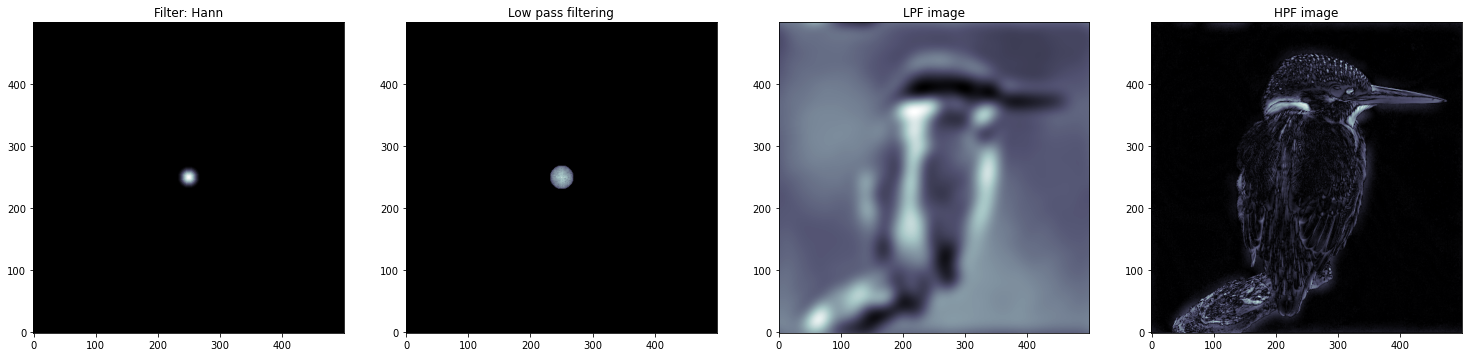

In [23]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

# Making filter
prof = np.hanning(diameter_filter)
filter_1d_hanning = (prof-np.min(prof))/np.max(prof-np.min(prof))
hanning_filter = filter_2d(filter_1d_hanning, Nframe)

filtered_hpf = ftshift_image2 * (1-hanning_filter)
filtered_lpf = ftshift_image2 * hanning_filter

rec_hpfh1 = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_hpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))
rec_lpfh1 = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_lpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))

plt.subplot(141), plt.imshow(hanning_filter, 'bone', origin='lower'), plt.title("Filter: Hann")
plt.subplot(142), plt.imshow(np.log(1+np.abs(filtered_lpf)), 'bone', origin='lower'), plt.title("Low pass filtering")
plt.subplot(143), plt.imshow(np.abs(rec_lpfh1), 'bone', origin='lower'), plt.title("LPF image")
plt.subplot(144), plt.imshow(np.abs(rec_hpfh1), 'bone', origin='lower'), plt.title("HPF image")
#plt.subplot(144), plt.imshow(np.abs(rec_lpfh1-rec_lpf), 'bone', origin='lower'), plt.title("LPF hann - LPF mask")

plt.show()

### 3-Hamming profile
$w(n) = 0.54 - 0.46 \cos(2\pi n/(M-1))$

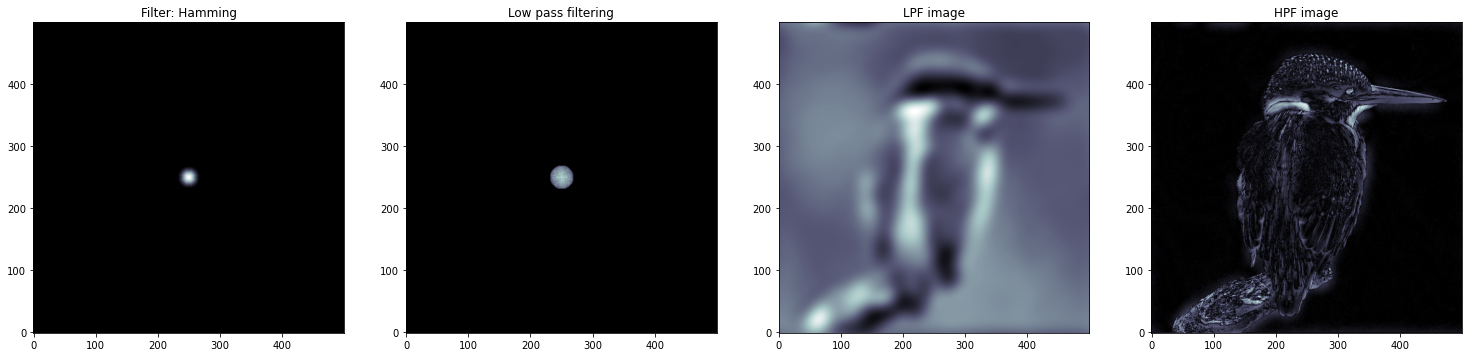

In [25]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

# Making filter
prof = np.hamming(diameter_filter)
filter_1d_hamming = (prof-np.min(prof))/np.max(prof-np.min(prof))
hamming_filter = filter_2d(filter_1d_hamming, Nframe)

filtered_hpf = ftshift_image2 * (1-hamming_filter)
filtered_lpf = ftshift_image2 * hamming_filter

rec_hpfh2 = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_hpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))
rec_lpfh2 = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_lpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))

plt.subplot(141), plt.imshow(hamming_filter, 'bone', origin='lower'), plt.title("Filter: Hamming")
plt.subplot(142), plt.imshow(np.log(1+np.abs(filtered_lpf)), 'bone', origin='lower'), plt.title("Low pass filtering")
plt.subplot(143), plt.imshow(np.abs(rec_lpfh2), 'bone', origin='lower'), plt.title("LPF image")
plt.subplot(144), plt.imshow(np.abs(rec_hpfh2), 'bone', origin='lower'), plt.title("HPF image")
#plt.subplot(144), plt.imshow(np.abs(rec_lpfh2-rec_lpf), 'bone', origin='lower'), plt.title("LPF hamming - LPF mask")

plt.show()

### 4-Blackman profile

$w(n) = 0.42 - 0.5 \cos(2\pi n/M) +0.08 \cos(4\pi n/M)$

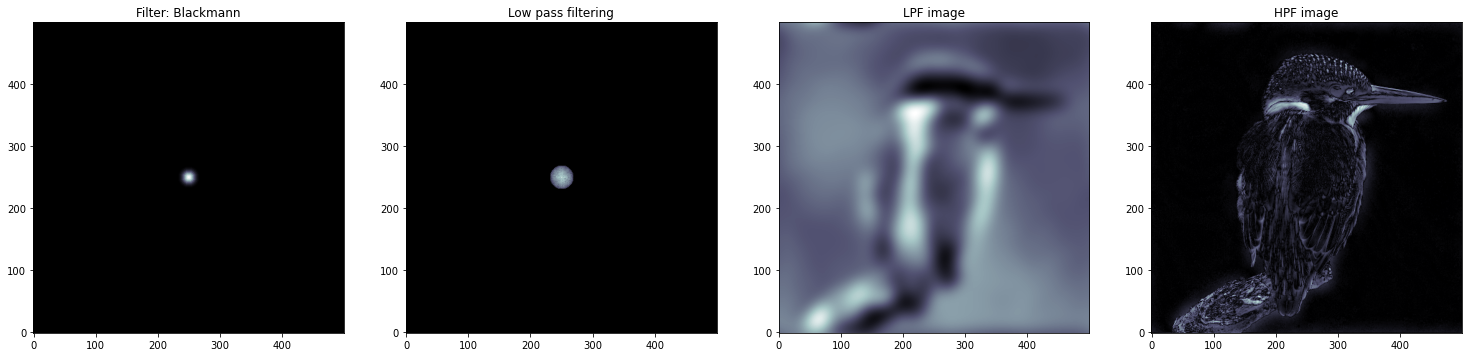

In [26]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

# Making filter
prof = np.blackman(diameter_filter)
filter_1d_blackman = (prof-np.min(prof))/np.max(prof-np.min(prof))
blackman_filter = filter_2d(filter_1d_blackman, Nframe)

filtered_hpf = ftshift_image2 * (1-blackman_filter)
filtered_lpf = ftshift_image2 * blackman_filter

rec_hpfbl = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_hpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))
rec_lpfbl = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_lpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))

plt.subplot(141), plt.imshow(blackman_filter, 'bone', origin='lower'), plt.title("Filter: Blackmann")
plt.subplot(142), plt.imshow(np.log(1+np.abs(filtered_lpf)), 'bone', origin='lower'), plt.title("Low pass filtering")
plt.subplot(143), plt.imshow(np.abs(rec_lpfbl), 'bone', origin='lower'), plt.title("LPF image")
plt.subplot(144), plt.imshow(np.abs(rec_hpfbl), 'bone', origin='lower'), plt.title("HPF image")
#plt.subplot(144), plt.imshow(np.abs(rec_lpfh2-rec_lpf), 'bone', origin='lower'), plt.title("LPF hamming - LPF mask")

plt.show()

### 5-Kaiser profile

$w(n) = I_0 ( \beta \sqrt{(1 - 4n^2 / (M-1)^2} / I_0 \beta)$

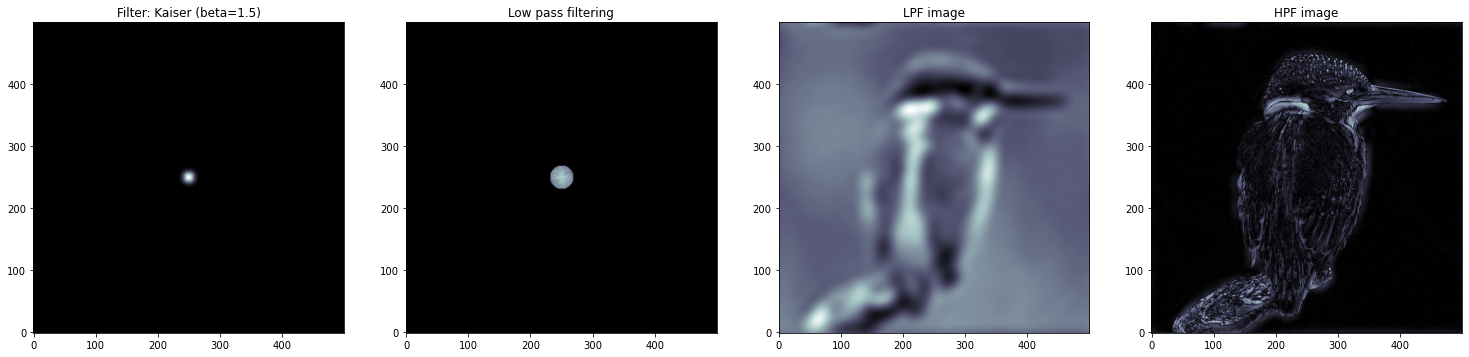

In [27]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

# Making filter
beta = 1.5
prof = np.kaiser(diameter_filter, beta)
filter_1d_kaiser = (prof-np.min(prof))/np.max(prof-np.min(prof))
kaiser_filter = filter_2d(filter_1d_kaiser, Nframe)

filtered_hpf = ftshift_image2 * (1-kaiser_filter)
filtered_lpf = ftshift_image2 * kaiser_filter

rec_hpfk = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_hpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))
rec_lpfk = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_lpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))

plt.subplot(141), plt.imshow(blackman_filter, 'bone', origin='lower'), plt.title("Filter: Kaiser (beta=1.5)")
plt.subplot(142), plt.imshow(np.log(1+np.abs(filtered_lpf)), 'bone', origin='lower'), plt.title("Low pass filtering")
plt.subplot(143), plt.imshow(np.abs(rec_lpfk), 'bone', origin='lower'), plt.title("LPF image")
plt.subplot(144), plt.imshow(np.abs(rec_hpfk), 'bone', origin='lower'), plt.title("HPF image")
#plt.subplot(144), plt.imshow(np.abs(rec_lpfh2-rec_lpf), 'bone', origin='lower'), plt.title("LPF hamming - LPF mask")

plt.show()

### 6-Bartlett

$w(n) = 2/(M-1) \times \left( (M-1)/2 - | n - (M-1)/2 | \right)$

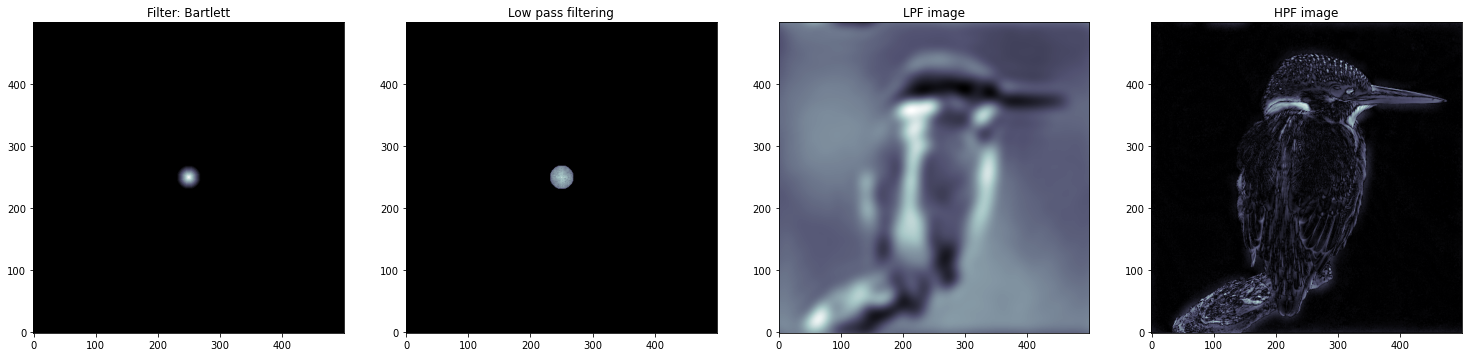

In [28]:
plt.figure(figsize=(6.4*4, 4.8*4), constrained_layout=False)

# Making filter
prof = np.bartlett(diameter_filter)
filter_1d_bartlett = (prof-np.min(prof))/np.max(prof-np.min(prof))
bartlett_filter = filter_2d(filter_1d_bartlett, Nframe)

filtered_hpf = ftshift_image2 * (1-bartlett_filter)
filtered_lpf = ftshift_image2 * bartlett_filter

rec_hpfba = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_hpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))
rec_lpfba = np.fft.ifft2(np.abs(np.fft.ifftshift(filtered_lpf))*np.exp(np.complex(0,1)*np.angle(ft_image2)))

plt.subplot(141), plt.imshow(bartlett_filter, 'bone', origin='lower'), plt.title("Filter: Bartlett")
plt.subplot(142), plt.imshow(np.log(1+np.abs(filtered_lpf)), 'bone', origin='lower'), plt.title("Low pass filtering")
plt.subplot(143), plt.imshow(np.abs(rec_lpfba), 'bone', origin='lower'), plt.title("LPF image")
plt.subplot(144), plt.imshow(np.abs(rec_hpfba), 'bone', origin='lower'), plt.title("HPF image")
#plt.subplot(144), plt.imshow(np.abs(rec_lpfh2-rec_lpf), 'bone', origin='lower'), plt.title("LPF hamming - LPF mask")

plt.show()

### All profiles

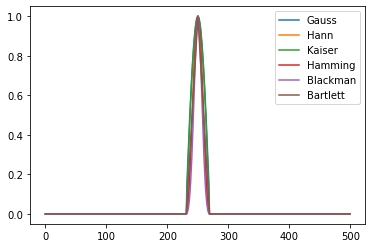

In [29]:
plt.plot(gauss_filter[Nframe//2,:], label = 'Gauss')
plt.plot(hanning_filter[Nframe//2,:], label = 'Hann')
plt.plot(kaiser_filter[Nframe//2,:], label = 'Kaiser')
plt.plot(hamming_filter[Nframe//2,:], label = 'Hamming')
plt.plot(blackman_filter[Nframe//2,:], label = 'Blackman')
plt.plot(bartlett_filter[Nframe//2,:], label = 'Bartlett')

plt.legend()
plt.show()

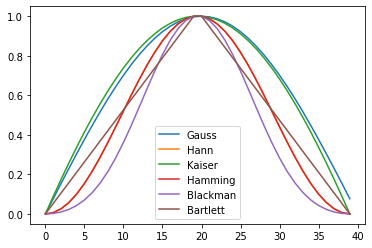

In [30]:
plt.plot(filter_1d_gauss, label = 'Gauss')
plt.plot(filter_1d_hamming, label = 'Hann')
plt.plot(filter_1d_kaiser, label = 'Kaiser')
plt.plot(filter_1d_hamming, label = 'Hamming')
plt.plot(filter_1d_blackman, label = 'Blackman')
plt.plot(filter_1d_bartlett, label = 'Bartlett')

plt.legend()
plt.show()

In [ ]:
#Next time: 
#do the same with a PSF ! 
#and assess how much flux is loss wrt the windows used :-)
###https://numpy.org/doc/stable/reference/routines.window.html###